In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print('mean:', mnist_train.data.float().div(255).mean())
print('std:', mnist_train.data.float().div(255).std())



mean: tensor(0.1307)
std: tensor(0.3081)


In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
print('mnist_train shape: ', mnist_train.data.shape)
print('mnist_test shape: ', mnist_test.data.shape)

mnist_train shape:  torch.Size([60000, 28, 28])
mnist_test shape:  torch.Size([10000, 28, 28])


In [5]:

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.first_conv = nn.Conv2d(
            stride=1,
            padding=1,
            kernel_size=3,
            in_channels=1,
            out_channels=16
        )
        # Out size = (28 + 2 -3 ) + 1 = 28
        self.second_conv = nn.Conv2d(
            stride=1,
            padding=1,
            kernel_size=3,
            in_channels=16,
            out_channels=32
        )
        # Out size = (28 + 2 -3 ) + 1 = 28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Out size = 28 / 2 = 14
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.first_conv(x))
        x = F.relu(self.second_conv(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [6]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

In [9]:
model = MNISTNet()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 2/469 [00:00<01:45,  4.43it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301623


 22%|██▏       | 103/469 [00:09<00:29, 12.23it/s]

Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.618612


 43%|████▎     | 203/469 [00:18<00:22, 12.07it/s]

Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.596367


 65%|██████▍   | 303/469 [00:27<00:15, 10.95it/s]

Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.562009


 86%|████████▌ | 403/469 [00:35<00:05, 11.96it/s]

Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.516013


100%|██████████| 469/469 [00:41<00:00, 11.39it/s]



Test set: Average loss: 1.4965, Accuracy: 9658/10000 (97%)



  0%|          | 2/469 [00:00<00:39, 11.69it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.531522


 22%|██▏       | 102/469 [00:09<00:32, 11.40it/s]

Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.492876


 43%|████▎     | 202/469 [00:18<00:22, 11.67it/s]

Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.511858


 64%|██████▍   | 302/469 [00:26<00:15, 11.00it/s]

Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.508075


 86%|████████▌ | 402/469 [00:35<00:05, 11.71it/s]

Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.522147


100%|██████████| 469/469 [00:41<00:00, 11.26it/s]



Test set: Average loss: 1.4858, Accuracy: 9757/10000 (98%)



  0%|          | 2/469 [00:00<00:38, 12.15it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.530944


 22%|██▏       | 102/469 [00:08<00:31, 11.78it/s]

Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.527088


 43%|████▎     | 202/469 [00:17<00:21, 12.30it/s]

Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.520661


 64%|██████▍   | 302/469 [00:25<00:14, 11.72it/s]

Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.502883


 86%|████████▌ | 403/469 [00:35<00:06, 10.65it/s]

Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.497869


100%|██████████| 469/469 [00:40<00:00, 11.51it/s]



Test set: Average loss: 1.4805, Accuracy: 9809/10000 (98%)



  0%|          | 2/469 [00:00<00:38, 11.99it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.493459


 22%|██▏       | 102/469 [00:08<00:32, 11.40it/s]

Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.499106


 43%|████▎     | 202/469 [00:17<00:23, 11.60it/s]

Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.504045


 64%|██████▍   | 302/469 [00:25<00:13, 12.21it/s]

Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.506116


 86%|████████▌ | 402/469 [00:35<00:07,  9.56it/s]

Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.496194


100%|██████████| 469/469 [00:41<00:00, 11.20it/s]



Test set: Average loss: 1.4784, Accuracy: 9831/10000 (98%)



  0%|          | 1/469 [00:00<00:59,  7.93it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.486978


 22%|██▏       | 102/469 [00:09<00:32, 11.43it/s]

Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.483461


 43%|████▎     | 202/469 [00:18<00:23, 11.37it/s]

Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.506482


 65%|██████▍   | 303/469 [00:27<00:14, 11.07it/s]

Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.514054


 86%|████████▌ | 403/469 [00:38<00:06,  9.82it/s]

Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.502279


100%|██████████| 469/469 [00:46<00:00, 10.13it/s]



Test set: Average loss: 1.4767, Accuracy: 9847/10000 (98%)



  0%|          | 1/469 [00:00<00:55,  8.47it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.484571


 22%|██▏       | 102/469 [00:12<00:44,  8.17it/s]

Train Epoch: 6 [12800/60000 (21%)]	Loss: 1.487508


 43%|████▎     | 202/469 [00:24<00:28,  9.27it/s]

Train Epoch: 6 [25600/60000 (43%)]	Loss: 1.475738


 64%|██████▍   | 302/469 [00:36<00:20,  8.21it/s]

Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.492870


 86%|████████▌ | 402/469 [00:48<00:07,  8.98it/s]

Train Epoch: 6 [51200/60000 (85%)]	Loss: 1.491534


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]



Test set: Average loss: 1.4761, Accuracy: 9850/10000 (98%)



  0%|          | 1/469 [00:00<00:54,  8.60it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.508269


 22%|██▏       | 102/469 [00:11<00:44,  8.28it/s]

Train Epoch: 7 [12800/60000 (21%)]	Loss: 1.470425


 43%|████▎     | 203/469 [00:23<00:24, 11.08it/s]

Train Epoch: 7 [25600/60000 (43%)]	Loss: 1.505792


 64%|██████▍   | 302/469 [00:33<00:15, 10.75it/s]

Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.491168


 86%|████████▌ | 402/469 [00:42<00:06, 10.77it/s]

Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.462498


100%|██████████| 469/469 [00:49<00:00,  9.46it/s]



Test set: Average loss: 1.4762, Accuracy: 9844/10000 (98%)



  0%|          | 1/469 [00:00<00:54,  8.59it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.489414


 22%|██▏       | 102/469 [00:10<00:36, 10.09it/s]

Train Epoch: 8 [12800/60000 (21%)]	Loss: 1.480423


 43%|████▎     | 202/469 [00:21<00:27,  9.60it/s]

Train Epoch: 8 [25600/60000 (43%)]	Loss: 1.500831


 64%|██████▍   | 302/469 [00:32<00:18,  9.27it/s]

Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.472044


 86%|████████▌ | 402/469 [00:43<00:07,  9.02it/s]

Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.476701


100%|██████████| 469/469 [00:50<00:00,  9.27it/s]



Test set: Average loss: 1.4749, Accuracy: 9864/10000 (99%)



  0%|          | 1/469 [00:00<01:11,  6.51it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.500702


 22%|██▏       | 102/469 [00:15<00:49,  7.36it/s]

Train Epoch: 9 [12800/60000 (21%)]	Loss: 1.477484


 43%|████▎     | 202/469 [00:28<00:37,  7.17it/s]

Train Epoch: 9 [25600/60000 (43%)]	Loss: 1.467128


 64%|██████▍   | 302/469 [00:42<00:19,  8.41it/s]

Train Epoch: 9 [38400/60000 (64%)]	Loss: 1.500658


 86%|████████▌ | 402/469 [00:54<00:07,  8.58it/s]

Train Epoch: 9 [51200/60000 (85%)]	Loss: 1.519834


100%|██████████| 469/469 [01:03<00:00,  7.44it/s]



Test set: Average loss: 1.4769, Accuracy: 9839/10000 (98%)



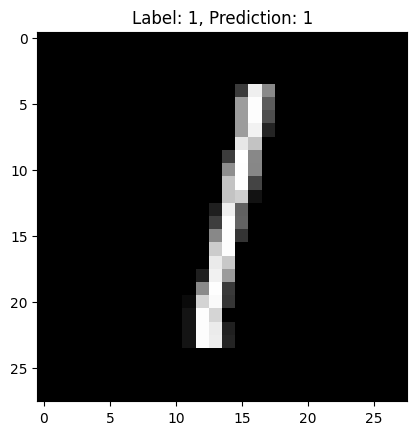

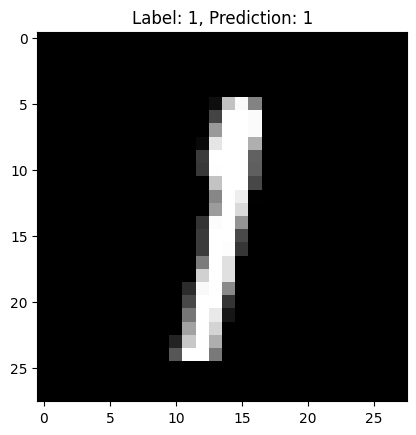

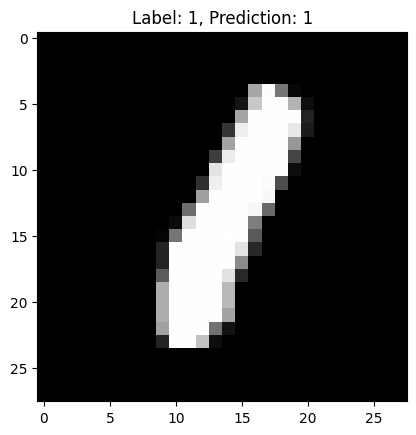

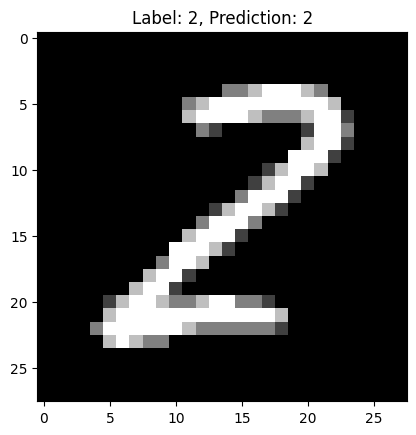

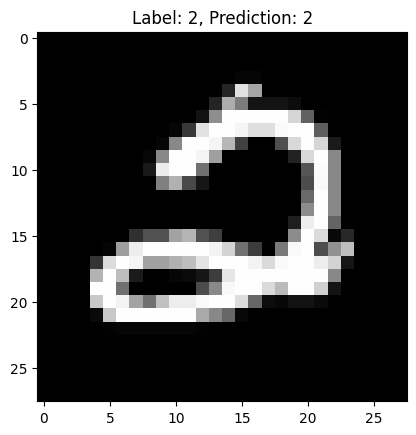

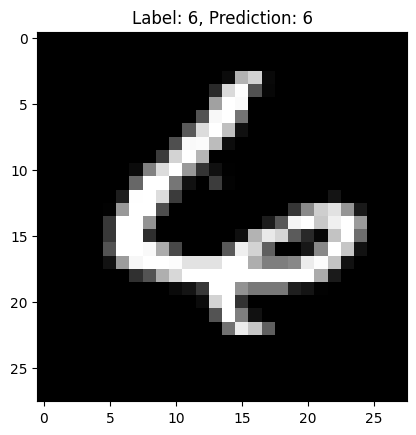

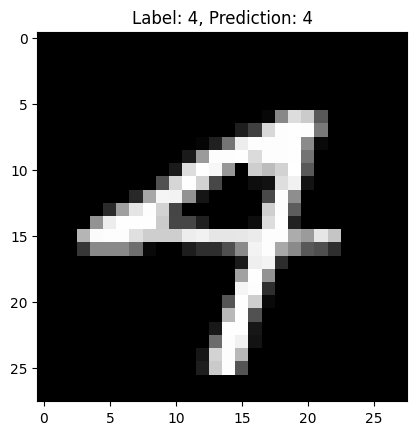

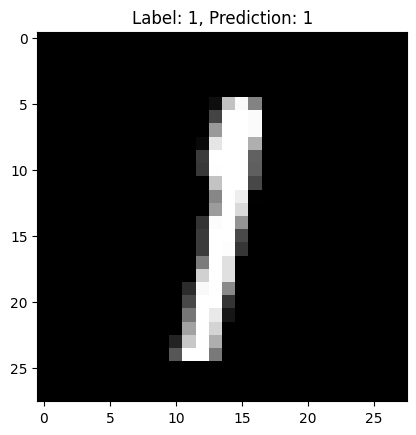

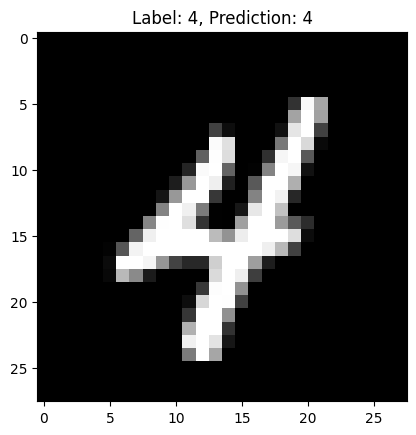

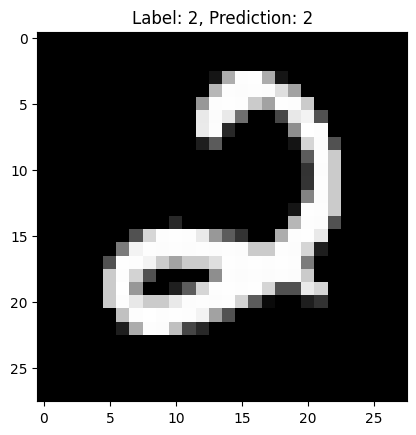

In [10]:
import matplotlib.pyplot as plt

for i in range(10):
    idx = np.random.randint(0, len(mnist_test))
    img = mnist_test.data[idx]
    label = mnist_test.targets[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).unsqueeze(0).float())
        pred = output.argmax(dim=1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}, Prediction: {pred.item()}')
        plt.show()
